In [3]:
!nvidia-smi

Wed Jun  8 22:41:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K40c          Off  | 00000000:02:00.0 Off |                    0 |
| 26%   52C    P0    62W / 235W |  11097MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K40c          Off  | 00000000:03:00.0 Off |                    0 |
| 28%   

In [4]:
gpus = [0]
import os
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [5]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *
from scipy.spatial import distance
import seaborn as sns

In [6]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [7]:
dataset = Dataset('Starling')
analysis = 'stable_length'

results_folder = os.path.abspath('/mnt/cube/kai/results/sound_texture/classifier')
species_folder = dataset.path_save
analysis_folder = os.path.join(species_folder, analysis)
log_folder = os.path.join(analysis_folder, 'log')

spec_file = sorted(glob(os.path.join(log_folder, 'all_specs_star.p')))[-1]

In [8]:
spec_df = pickle.load(open(spec_file, 'rb'))

In [9]:
spec_list = spec_df.spec.values.tolist()

In [10]:
h, w = spec_list[0].shape

## make model and load weights

In [11]:
clear_session()

In [12]:
model=self_VGG(weights='imagenet')

In [13]:
model_inputs = Input(shape=(h, w//3, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
model_outputs = model(resized)
feature_extractor = Model(model_inputs, model_outputs)

# First we test how shifting the frame affect loss
This is what traditional spectrogram rmse is proven to be bad at.

## This is accomplished by eliminating top or bottom portion of the spectrogram 

In [14]:
def slice_shift(spec, n_slices, axis=0):
    '''
    The function shifts each spectrogram in horizontal or vertical axis. The algorithm works by taking n_slices to
    the right and move them to the left, or in the case of vertical shift, taking n_slices to the top and move to the
    bottom
    
    spec needs to be 2D, not a 3D image
    '''
    assert len(spec.shape)==2
    h, w = spec.shape
    if axis==0:
        permutation = list(np.arange(h-n_slices, h, dtype=int)) + list(range(h-n_slices))
        shifted = spec[permutation, :]
    elif axis==1:
        permutation = list(np.arange(w-n_slices, w, dtype=int)) + list(range(w-n_slices))
        shifted = spec[:, permutation]
    return shifted

In [15]:
orig_spec = chosen_specs[1][30:]
plt.imshow(orig_spec, origin='lower')

NameError: name 'chosen_specs' is not defined

In [ ]:
shifted_spec = chosen_specs[1][:261]
plt.imshow(shifted_spec, origin='lower')

In [ ]:
np.sqrt(np.mean(np.square(orig_spec-shifted_spec)))

## We randomly choose 10 spectrograms, shift each spectrogram by 1~h/2 slices, where h is the total height (number of spectral slices)

In [41]:
chosen_specs = random.sample(spec_list, 10)

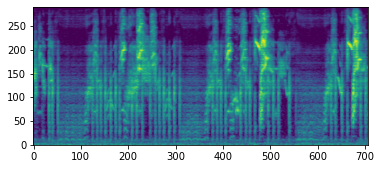

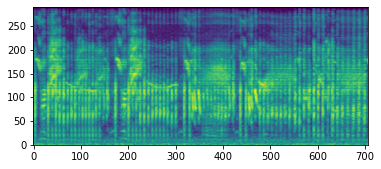

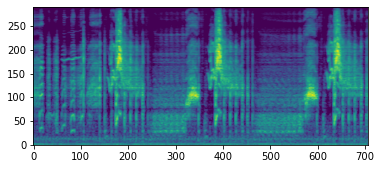

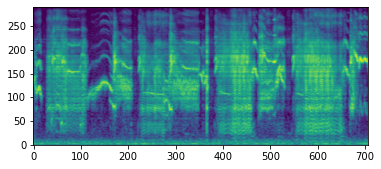

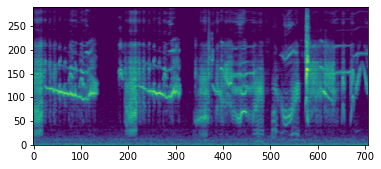

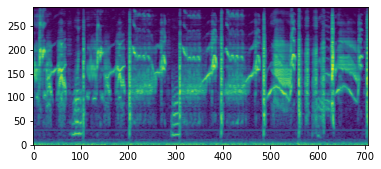

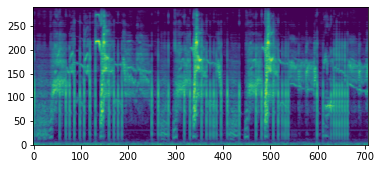

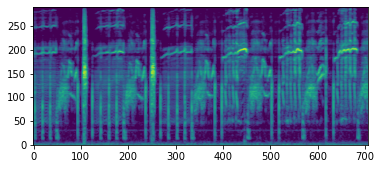

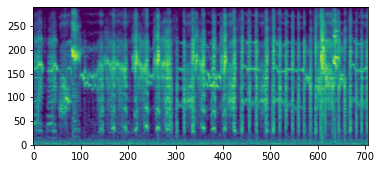

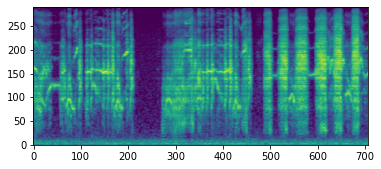

In [43]:
for spec in chosen_specs:
    plt.figure()
    plt.imshow(spec, origin='lower')

In [44]:
pickle.dump(chosen_specs, open('/mnt/cube/kai/results/perceptual_loss/10_specs.p', 'wb'))

In [17]:
chosen_specs = pickle.load(open('/mnt/cube/kai/results/perceptual_loss/10_specs.p', 'rb'))

In [18]:
h, w = chosen_specs[0].shape

In [19]:
spec_index_list = []
n_slices_list = []
feature_rmse_list = []
feature_cosine_list = []
spec_rmse_list = []

divided_w = w//3
for spec_i, spec in enumerate(chosen_specs):
    for i in range(3):  #divide into 3 slices
        orig_spec = spec[:, divided_w*i:divided_w*(i+1)]
        for n_slices in range(15):  # number of slices to extract
#                 permuted_spec = slice_shift(orig_spec, n_slices)
            blank_spec = np.full((n_slices+1, divided_w), -1, dtype=float)
            top_spec = np.vstack((blank_spec, orig_spec))
            bottom_spec = np.vstack((orig_spec, blank_spec))
            top_3d = np.stack([top_spec, top_spec, top_spec], axis = 2)
            bottom_3d = np.stack([bottom_spec, bottom_spec, bottom_spec], axis = 2)

            top_features = np.squeeze(feature_extractor.predict(np.expand_dims(top_3d, axis=0)))
            bottom_features = np.squeeze(feature_extractor.predict(np.expand_dims(bottom_3d, axis=0)))

            spec_index_list.append(spec_i*3+i)
            n_slices_list.append(n_slices+1)
            feature_rmse_list.append(rmse(top_features, bottom_features))
            feature_cosine_list.append(distance.cosine(top_features, bottom_features)/2)
            spec_rmse_list.append(rmse(top_3d, bottom_3d))

            if n_slices%50==0:
                paragraph_print(f'>>{n_slices}', separation='>')
                
    paragraph_print(f'Done with {spec_i}', separation='*')

>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Done with 0
**************************************************
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Done with 1
**************************************************
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Done with 2
**************************************************
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Done with 3
**************************************************
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [20]:
TB_df = pd.DataFrame()
TB_df['spec'] = spec_index_list
TB_df['n_slices'] = n_slices_list
TB_df['feature_rmse'] = feature_rmse_list
TB_df['feature_cosine'] = feature_cosine_list
TB_df['spec_rmse'] = spec_rmse_list

In [21]:
TB_df_melt = pd.melt(TB_df, id_vars=['spec', 'n_slices'], 
                     value_vars=['feature_cosine','spec_rmse'],
                     var_name='metric')

In [22]:
name_dict = {'feature_cosine': 'APD', 'spec_rmse': 'MSE'}

In [23]:
TB_df_melt['metric'] = TB_df_melt['metric'].apply(lambda x: name_dict[x])

In [26]:
custom_palette = {'MSE':'red', 'APD':'lightskyblue'}

In [30]:
matplotlib.rcParams.update({'font.size': 14})

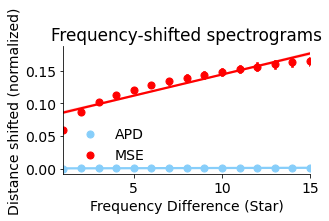

In [31]:
g = sns.lmplot(x='n_slices', y='value', data=TB_df_melt, hue='metric', x_estimator=np.mean, height=2.5, aspect=1.8,
           legend=False, palette=custom_palette
            )
plt.title('Frequency-shifted spectrograms')
plt.xlabel('Frequency Difference (Star)')
plt.ylabel('Distance shifted (normalized)')
plt.legend(frameon=False)
plt.savefig('imagenetfreq.pdf', transparent=True)

In [24]:
TB_df_melt.head()

,spec,n_slices,metric,value
0,0,1,APD,0.000465
1,0,2,APD,0.001227
2,0,3,APD,0.001429
3,0,4,APD,0.001478
4,0,5,APD,0.001508


In [29]:
TB_df_melt[TB_df_melt.n_slices==1].groupby('metric')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
metric,,,,,,,,
APD,30.0,0.003161,0.001459,0.000352,0.002133,0.002897,0.004076,0.006680
MSE,30.0,0.058860,0.003129,0.053608,0.057017,0.058054,0.059831,0.065604


In [30]:
TB_df_melt.groupby('metric')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
metric,,,,,,,,
APD,450.0,0.019704,0.014275,0.000352,0.008427,0.014953,0.028209,0.071271
MSE,450.0,0.131152,0.031726,0.053608,0.114262,0.135205,0.152964,0.191401


In [31]:
TB_MSE_n_slices = TB_df_melt[TB_df_melt.metric=='MSE'].n_slices.values.reshape(-1, 1)
TB_MSE_val = TB_df_melt[TB_df_melt.metric=='MSE'].value.values.reshape(-1, 1)

In [32]:
TB_APD_n_slices = TB_df_melt[TB_df_melt.metric=='APD'].n_slices.values.reshape(-1, 1)
TB_APD_val = TB_df_melt[TB_df_melt.metric=='APD'].value.values.reshape(-1, 1)

In [33]:
TB_MSE = LinearRegression()

In [34]:
TB_MSE.fit(TB_MSE_n_slices, TB_MSE_val)

LinearRegression()

In [35]:
TB_MSE.score(TB_MSE_n_slices, TB_MSE_val)

0.773251165709715

In [36]:
TB_MSE.coef_

array([[0.00644989]])

In [37]:
TB_APD = LinearRegression()
TB_APD.fit(TB_APD_n_slices, TB_APD_val)
print(TB_APD.score(TB_APD_n_slices, TB_APD_val))
print(TB_APD.coef_)

0.5246666892874068
[[0.00239063]]


# horizontal shift

In [32]:
spec_index_list = []
n_slices_list = []
feature_rmse_list = []
feature_cosine_list = []
spec_rmse_list = []

divided_w = w//3
for spec_i, spec in enumerate(chosen_specs):
    for i in range(3):  #divide into 3 slices
        orig_spec = spec[:, divided_w*i:divided_w*(i+1)]
        for n_slices in range(15):  # number of slices to extract
#                 permuted_spec = slice_shift(orig_spec, n_slices)
            blank_spec = np.full((h, n_slices+1), -1, dtype=float)
            left_spec = np.hstack((blank_spec, orig_spec))
            right_spec = np.hstack((orig_spec, blank_spec))
            left_3d = np.stack([left_spec, left_spec, left_spec], axis = 2)
            right_3d = np.stack([right_spec, right_spec, right_spec], axis = 2)

            left_features = np.squeeze(feature_extractor.predict(np.expand_dims(left_3d, axis=0)))
            right_features = np.squeeze(feature_extractor.predict(np.expand_dims(right_3d, axis=0)))

            spec_index_list.append(spec_i*3+i)
            n_slices_list.append(n_slices+1)
            feature_rmse_list.append(rmse(left_features, right_features))
            feature_cosine_list.append(distance.cosine(left_features, right_features)/2)
            spec_rmse_list.append(rmse(left_3d, right_3d))

            if n_slices%50==0:
                paragraph_print(f'>>{n_slices}', separation='>')
                
    paragraph_print(f'Done with {spec_i}', separation='*')

>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Done with 0
**************************************************
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Done with 1
**************************************************
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Done with 2
**************************************************
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Done with 3
**************************************************
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [33]:
LR_df = pd.DataFrame()
LR_df['spec'] = spec_index_list
LR_df['n_slices'] = n_slices_list
LR_df['feature_rmse'] = feature_rmse_list
LR_df['feature_cosine'] = feature_cosine_list
LR_df['spec_rmse'] = spec_rmse_list

In [34]:
LR_df_melt = pd.melt(LR_df, id_vars=['spec', 'n_slices'], 
                     value_vars=['feature_cosine','spec_rmse'],
                     var_name='metric')

In [35]:
LR_df_melt[LR_df_melt.n_slices==1].groupby('metric')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
metric,,,,,,,,
feature_cosine,30.0,0.000239,0.000113,0.000067,0.000160,0.000210,0.000311,0.000501
spec_rmse,30.0,0.060276,0.010217,0.044719,0.052085,0.059997,0.067112,0.083476


In [36]:
LR_df_melt.groupby('metric')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
metric,,,,,,,,
feature_cosine,450.0,0.000647,0.000282,0.000067,0.000460,0.000612,0.000802,0.001609
spec_rmse,450.0,0.175285,0.051064,0.044719,0.148928,0.185232,0.208100,0.317041


In [37]:
name_dict = {'feature_cosine': 'APD', 'spec_rmse': 'MSE'}

In [38]:
LR_df_melt['metric'] = LR_df_melt['metric'].apply(lambda x: name_dict[x])

In [39]:
LR_APD = LR_df_melt[LR_df_melt.metric=='APD']['value'].values.tolist()

In [123]:
from scipy import stats

t_value,p_value=stats.ttest_1samp(LR_APD, 0)

In [124]:
t_value

14.556963323880836

In [125]:
p_value

1.344682327791063e-39

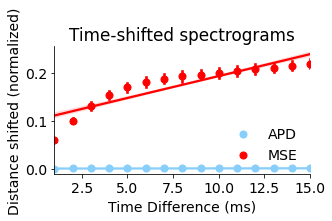

In [40]:
g = sns.lmplot(x='n_slices', y='value', data=LR_df_melt, hue='metric', x_estimator=np.mean, height=2.5, aspect=1.8,
           legend=False, palette=custom_palette
            )
plt.title('Time-shifted spectrograms')
plt.xlabel('Time Difference (ms)')
plt.ylabel('Distance shifted (normalized)')
plt.legend(frameon=False)
plt.savefig('imagenettime.pdf', transparent=True)